# EDA — Classification de paroles (Rap vs Variété Française)

Ce notebook se concentre sur l’**exploration** et la **compréhension** des données (EDA) avant toute modélisation.

**Objectifs :**
- Décrire le dataset (taille, genre, artistes).
- Explorer la structure des textes (longueur, vocabulaire, signaux linguistiques).

## 0. Imports & configuration

In [1]:
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Chargement des données

Le dossier `data/` contient :
- `data/chansons/Rap/*.csv`
- `data/chansons/VF/*.csv`
- `data/stopword.txt` (liste custom)

Chaque CSV correspond à un artiste et contient notamment la colonne `lyrics`.

In [2]:
data_dir = Path("data")
rap_dir = data_dir / "chansons" / "Rap"
vf_dir = data_dir / "chansons" / "VF"
stopword_file = data_dir / "stopword.txt"
# Fonction permettant de charger les données à partir d'un path contenant les fichiers csv
def load_data(path, label):
    dfs = []
    for csv_path in sorted(path.glob("*.csv")):
        songs = pd.read_csv(csv_path)
        # Supprime les colonnes d'index parasites type 'Unnamed: 0'
        songs = songs.loc[:, ~songs.columns.str.contains(r"^Unnamed")]
        songs["auteur"] = csv_path.stem
        songs["genre"] = label
        dfs.append(songs.drop(columns=["time"]))
    return pd.concat(dfs, ignore_index=True)

In [3]:
# Chargement des chansons de Rap
rap = load_data(rap_dir, "Rap")

In [4]:
rap.shape

(915, 4)

In [5]:
# Chargement des chansons de VF
vf  = load_data(vf_dir,  "VF")

In [6]:
# Concaténation des données
df = pd.concat([rap, vf], ignore_index=True)
print("\nTotal : ",df.shape[0]," chansons")
df.head()


Total :  2633  chansons


,song,lyrics,auteur,genre
0,"Bad Boys de Marseille, Pt. 2w/ La Fonky Family","(Bad boys) canailles, canailles, les mauvais g...",Akhenaton,Rap
1,Bad Boys de Marseille,"Chaud comme Marseille, on vous met le feu Le ...",Akhenaton,Rap
2,Le Calme Comme Essence,"Le vacarme des humains, parfois me rend patraq...",Akhenaton,Rap
3,La Cosca,"Ma famille est sept fois séculaire, ancienne e...",Akhenaton,Rap
4,Je Ne Suis Pas à Plaindre,C'était un jour de pluie où l'on n'aime pas me...,Akhenaton,Rap


In [7]:
missing = df.isna().sum()
missing

song      0
lyrics    0
auteur    0
genre     0
dtype: int64

### Répartition par genre
On visualise le nombre de chansons par genre pour repérer un **déséquilibre** potentiel 

In [8]:
df["genre"].value_counts()

genre
VF     1718
Rap     915
Name: count, dtype: int64

## 2. Prétraitement léger pour l’EDA (tokenisation)

Pour l’EDA, on utilise une tokenisation simple.

La tokenisation consiste à découper un texte en petits éléments appelés tokens (souvent des mots ou des phrases).
On peut tokeniser en Python de plusieurs façons :
- avec NLTK : word_tokenize() (mots) ou sent_tokenize() (phrases)
- ou plus simplement avec la méthode de base : split() (sépare sur les espaces)

Quand on tokenise un texte, la ponctuation peut apparaître comme des tokens à part (ex. “!”, “?”, “…”).
Dans ce projet, on s’intéresse surtout au vocabulaire (mots utilisés) et pas à l’intention d’une phrase (question/affirmation) comme dans le cas d'un NLU. On va donc retirer la ponctuation et mettre tout en minuscules.

Objectif : écrire une fonction tokenizer(texte) qui découpe en mots, met en minuscules, enlève la ponctuation, et renvoie uniquement des tokens non vides.


> La modélisation (notebook 02) utilisera ensuite un pipeline scikit-learn (TF‑IDF) pouvant intégrer d’autres variantes.


In [9]:
def tokenize(texte):
    """
    Prend une phrase en entrée et :
    - passe en minuscules
    - supprime une liste de ponctuation donnée
    - découpe en tokens (split)
    - renvoie uniquement les tokens non vides
    """
    # minuscules
    texte = texte.lower()
    # suppression de la ponctuation demandée
    ponctuation = [",", "-", ":", "!", "?", ".", "...", "'","’", "(", ")"]
    for p in ponctuation:
        texte = texte.replace(p, " ")
    # tokenisation (split sur les espaces)
    tokens = texte.split()
    # ne garder que les tokens non vides
    tokens = [t for t in tokens if t.strip() != ""]
    return tokens

### Nombre de mots par chanson

In [10]:
df["tokens"] = df["lyrics"].map(tokenize)
df["nb_mots"] = df["tokens"].map(len)
df[["genre","auteur","song","nb_mots"]].head()

,genre,auteur,song,nb_mots
0,Rap,Akhenaton,"Bad Boys de Marseille, Pt. 2w/ La Fonky Family",666
1,Rap,Akhenaton,Bad Boys de Marseille,884
2,Rap,Akhenaton,Le Calme Comme Essence,716
3,Rap,Akhenaton,La Cosca,744
4,Rap,Akhenaton,Je Ne Suis Pas à Plaindre,598


### Nombre de mots moyen par auteur

In [11]:
df_mots_moyen = (df.groupby(["genre","auteur"])['nb_mots']
        .agg(nb_chansons='size', nb_mots_moyen='mean')
        .reset_index())
df_mots_moyen.head()

,genre,auteur,nb_chansons,nb_mots_moyen
0,Rap,Akhenaton,34,621.323529
1,Rap,Booba,196,556.994898
2,Rap,Diam_s,19,740.684211
3,Rap,IAM,172,671.343023
4,Rap,JUL,7,617.142857


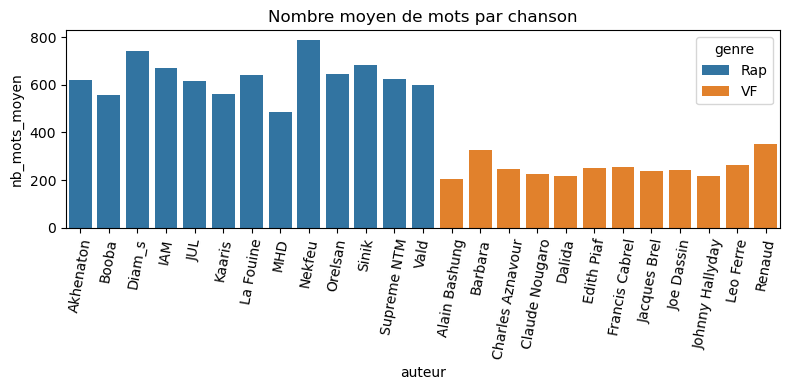

In [12]:
plt.figure(figsize=(8, 4))
sns.barplot(data=df_mots_moyen, x="auteur", y="nb_mots_moyen", hue="genre")
plt.xticks(list(np.arange(df_mots_moyen.shape[0])), df_mots_moyen.auteur, rotation=80)
plt.title("Nombre moyen de mots par chanson")
plt.tight_layout()
plt.show()

**Différence de longueur très marquée** : les paroles Rap sont **en moyenne beaucoup plus longues** que les paroles VF.

## Vocabulaire : nombre de mots différents utilisés par chaque artiste pour toutes leurs chansons

In [13]:
authors = df['auteur'].unique()
df_mots_diff=[]
for artist in authors:
    text = ' '.join(df.loc[df['auteur']==artist,'lyrics'].astype(str))
    tokens = tokenize(text)
    df_mots_diff.append({'auteur':artist, 
                           'nb_mots_total':len(tokens), 
                           'nb_mots_diff':len(set(tokens)), 
                           'genre':df.loc[df['auteur']==artist,'genre'].iloc[0]})
df_mots_diff = pd.DataFrame(df_mots_diff).sort_values('nb_mots_diff', ascending=False)
df_mots_diff.head()

,auteur,nb_mots_total,nb_mots_diff,genre
3,IAM,115471,13033,Rap
1,Booba,109171,12376,Rap
6,La Fouine,119778,10259,Rap
24,Renaud,75474,8769,VF
16,Claude Nougaro,40810,6436,VF


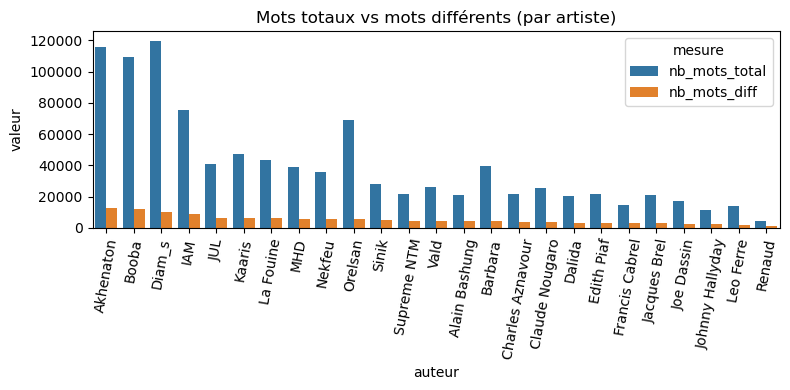

In [14]:
plot_df = df_mots_diff.melt(id_vars="auteur", value_vars=["nb_mots_total", "nb_mots_diff"], var_name="mesure", value_name="valeur")
plt.figure(figsize=(8, 4))
sns.barplot(data=plot_df, x="auteur", y="valeur", hue="mesure")
plt.xticks(list(np.arange(df_mots_moyen.shape[0])), df_mots_moyen.auteur, rotation=80)
plt.title("Mots totaux vs mots différents (par artiste)")
plt.tight_layout()
plt.show()

## 3. Etude des mots les plus fréquents

#### Affichons les 20 mots les plus fréquents de "Joe Dassin"

In [15]:
text=' '.join(df[df['auteur']=='Joe Dassin'].lyrics)
all_token=tokenize(text.lower())
total_term_frequency = Counter(all_token)
total_term_frequency.most_common(20)

[('la', 1042),
 ('de', 663),
 ('à', 561),
 ('et', 523),
 ('on', 402),
 ('un', 385),
 ('le', 375),
 ('est', 364),
 ('tu', 339),
 ('je', 333),
 ('a', 319),
 ('que', 303),
 ('les', 291),
 ('pas', 267),
 ('l', 257),
 ('qui', 254),
 ('il', 232),
 ('des', 213),
 ('dans', 210),
 ('n', 189)]

On remarque clairement que les mots les plus fréquents ne sont pas très intéressant du point de vue de l'analyse. Ces mots sont appelés **stop-words**. Une première phase de filtrage consiste à supprimer toutes les entrées qui correspondent aux mots outils classiques (déterminants, pronoms, ...).

Suivant le cas d’usage à traiter il est pertinent de supprimer (ou non) ces stopworks. Effectivement dans l’exemple de l’analyse de la satisfaction client (= analyse de sentiment) où à partir d’un texte on souhaite attribuer un score d’humeur, il est parfaitement crucial de garder les négations « ne pas » ou même la ponctuation. 
A l’inverse dans notre situation les stopwords n’apportent aucune nouvelle information pertinente et les supprimer semble être la meilleure stratégie.


<p style='text-align: justify'>Il existe dans la librairie NLTK une liste par défaut des stopwords dans plusieurs langues, notamment le français. En français, la librairie <code>nltk</code> propose une liste de stop-words en utilisant l'objet <code>stopwords.words('french')</code> de la classe <code>nltk.corpus</code>.</p>

### Supprimez dans le corpus des rappeurs l'ensemble des stopworks en utilisant le package nltk
<p style='text-align: justify'>L'idée est de parcourir l’ensemble des <code>tokens</code> et de vérifier pour chacun s’ils appartiennent à la liste des stopwords.</p>

In [16]:
from nltk.corpus import stopwords
french_stopwords = stopwords.words('french')
print(french_stopwords)

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aur

In [17]:
corpus_rappeur=text=' '.join(df[df.genre=='Rap'].lyrics)
all_token=tokenize(text.lower())
token_filtre=[]
for w in all_token:
    if w.lower() not in french_stopwords:
        token_filtre.append(w.lower())
total_term_frequency = Counter(token_filtre)
total_term_frequency.most_common(20)

[('a', 5117),
 ('comme', 3193),
 ('ça', 2628),
 ('tout', 2313),
 ('plus', 2257),
 ('si', 2227),
 ('quand', 1904),
 ('fait', 1744),
 ('faire', 1588),
 ('fais', 1429),
 ('rien', 1352),
 ('vie', 1219),
 ('tous', 1140),
 ('va', 1124),
 ('veux', 1119),
 ('bien', 1090),
 ('trop', 1085),
 ('sans', 1025),
 ('là', 975),
 ('où', 942)]

On se rend compte que la liste des stop-words fournies par <code>nltk</code> est incomplète. Ainsi on va compléter la liste des stop-words par le fichier.

De plus il est recommandé de supprimer en plus de la liste des stop-words les 20 mots les plus fréquents et les mots de moins de 3 lettres.

In [18]:
# stopwords en set
sw_fr = set(french_stopwords)
# Chargement des stop-words complémentaires
with open(stopword_file, encoding="utf-8") as f:
    sw_custom = {w.strip().lower() for w in f.read().split(",") if w.strip()}
STOP = sw_fr | sw_custom  # union

def top_terms_by_genre(df, genre, tokenizer, stop_set=STOP, min_len=4, top_remove=20, top_show=20):
    # concat toutes les paroles du genre
    text = " ".join(df.loc[df["genre"] == genre, "lyrics"].astype(str)).lower()
    # tokenize + filtre (stopwords + longueur)
    tokens = [t.lower() for t in tokenizer(text) if len(t) >= min_len and t.lower() not in stop_set]
    # fréquence globale
    tf = Counter(tokens)
    # mots à supprimer (top_remove)
    to_remove = {w for w, _ in tf.most_common(top_remove)}
    # refiltre + fréquence finale
    tokens_filtre = [t for t in tokens if t not in to_remove]
    tf2 = Counter(tokens_filtre)
    return tokens_filtre, tf2.most_common(top_show)

# Résultats
tokens_filtre_rap, top_rap = top_terms_by_genre(df, "Rap", tokenize)
tokens_filtre_vf, top_vf  = top_terms_by_genre(df, "VF", tokenize)

print("RAP :", top_rap)
print("\nVF :", top_vf)

RAP : [('tête', 516), ('laisse', 514), ('gros', 513), ('donne', 488), ('reste', 473), ('passe', 465), ('seul', 460), ('soir', 454), ('viens', 443), ('vois', 439), ('parle', 434), ('peut', 420), ('peux', 418), ('alors', 405), ('encore', 400), ('personne', 397), ('crois', 391), ('frère', 388), ('sale', 388), ('dire', 388)]

VF : [('ciel', 468), ('petit', 442), ('peut', 439), ('beau', 435), ('voir', 432), ('soir', 412), ('dire', 400), ('fais', 400), ('bras', 396), ('tant', 386), ('homme', 382), ('love', 381), ('puis', 367), ('belle', 362), ('mots', 362), ('fois', 357), ('seul', 355), ('terre', 352), ('grand', 340), ('soleil', 324)]


### Wordcloud comparatif (Rap vs VF)
Le wordcloud permet de visualiser rapidement les termes dominants après suppression des stopwords.

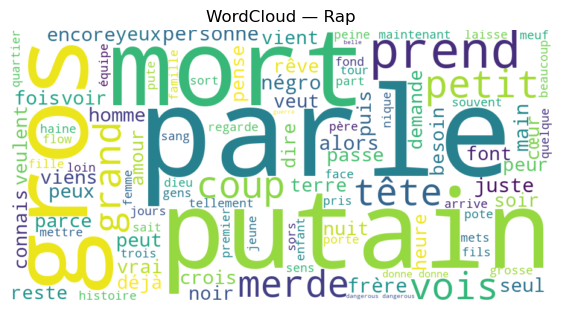

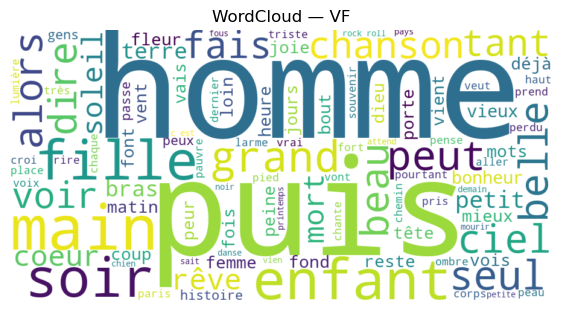

In [19]:
from wordcloud import WordCloud
def make_wordcloud(tokens, genre, max_words=100):
    wc = WordCloud(background_color='white', max_words=max_words, width=900, height=450)
    wc = wc.generate(' '.join(tokens))
    plt.figure(figsize=(7,5))
    plt.imshow(wc.to_image(), interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud — {genre}')
    plt.show()

for tok, g in zip([tokens_filtre_rap, tokens_filtre_vf], ["Rap", "VF"]):
    make_wordcloud(tok, g)

## 4. Conclusion
L’analyse exploratoire met en évidence des **différences marquées** entre les paroles de Rap et de Variété Française : **longueur des textes**, **vocabulaire dominant**, et certains **motifs lexicaux** spécifiques à chaque genre. Ces éléments suggèrent qu’il existe un signal **discriminant exploitable**.

L’étape suivante consiste à vérifier si ce signal permet de **prédire automatiquement** le genre d’une chanson à partir de ses paroles. Nous allons donc construire un pipeline de classification de textes.

## Recommandations
- **Déséquilibre des classes** : VF est plus représentée que Rap → utiliser `stratify` et éventuellement `class_weight='balanced'`.